# The prior of the linear model
Now that we have the likelihood, let's have a look at the prior. We have three parameters in our model and likelihood function: $\beta_0$, $\beta_1$ and $\sigma$. Again, the prior reflect the belief we have about which values are most likely for each parameters. So you might already think about what that could look like. If you have some knowledge about what values $\beta_0$, $\beta_1$ could look like, you can imagine that the prior should be a distribution centered around those values for those parameters, with max likelihood around those values and decreasing when you go lower or higher than that. 

So yeah, some sort of a normal distribution of sorts. Typically, you wouldn't have a guess about the precise value of the parameters, but you'd know that there are some values that are more realistic than others. So you can specify the priors for these parameters with some mean and variance parameters that kind of make sense. For our particular example, since you are wonder whether there is a relationship between penguin flipper length and their weight, you can imagine that the values around 0 should be quite likely and that very large values are less likely. And for the $\beta_0$ parameter, even if you don't know the actual mean weight of penguin, you know it's probably not 500g and probably not 750Kg , so something in between. So you can play around with the normal distribution to find parameters that seem reasonable (that's how I got the parameters below):

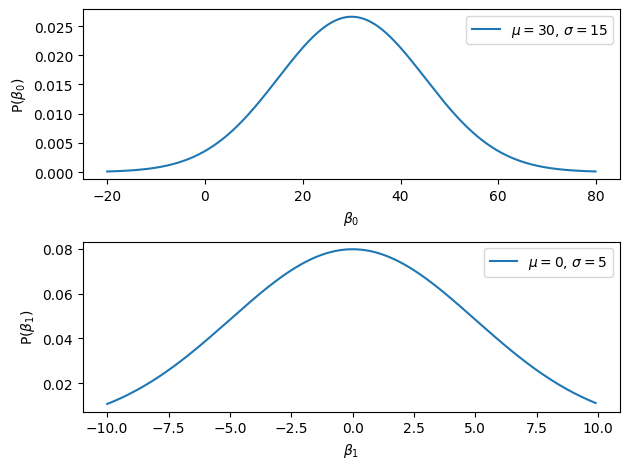

In [25]:
import numpy as np
import matplotlib.pyplot as plt

# Functions created in previous sections:
def normal_pdf(x, mu, sigma):
    p_x = (1/(np.sqrt(2*np.pi*sigma**2))) * np.e**(-((x-mu)**2)/(2*sigma**2))
    return p_x


# Parameters for the beta0 and beta1 prior distributions:
b0_mu = 30  # I think a penguin weighting 30kg seems about right
b0_sig = 15  # To set this parameter, I played around until I got a distribution that seem reasonable
b1_mu = 0  # I think the values of b1 should be close to 0. I think there may be a relationship between the two variables, but I dont' know if it's a positive or a negative relationship, which means that positive and negative values are equally likely a priori
b1_sig = 5  # This is quite large, which means that many values of b1 are plausible

xs = np.arange(-5, 5, 0.1)  # Define values of x

fig, ax = plt.subplots(2)
xs = np.arange(b0_mu-50, b0_mu+50, 0.1)  # Define values of x
ax[0].plot(xs, [normal_pdf(x, b0_mu, b0_sig) for x in xs], label=f'$\\mu={b0_mu}$, $\\sigma={b0_sig}$')
ax[0].set_ylabel('P($\\beta_0$)')
ax[0].set_xlabel('$\\beta_0$')
ax[0].legend()

xs = np.arange(b1_mu-10, b1_mu+10, 0.1)  # Define values of x
ax[1].plot(xs, [normal_pdf(x, b1_mu, b1_sig) for x in xs], label=f'$\\mu={b1_mu}$, $\\sigma={b1_sig}$')
ax[1].set_ylabel('P($\\beta_1$)')
ax[1].set_xlabel('$\\beta_1$')
ax[1].legend()
plt.tight_layout()
plt.show()
plt.close()

These seems about right: I think most penguin weight less than 80Kg, and I don't think that the correlation between the flipper length and the penguin weight will be much more than 10 or -10, cause that would mean that for every increase of 1mm in penguin flipper length, they gain 10kg, that just feels a bit much. Are these priors good? This is one of the main reason people are skeptical about Bayesian statistics: the definition of the priors influence the posterior. Since the priors can be set up arbitrarily, some people argue that this opens up the door for subjectivity in the analysis and that we can tweak the priors to get any results we want. We will see later on that there are ways in which we can make sure that that's not the case and that our analysis is sound. But in this cpahter I will stick to picking values that seem reasonable. 

What about the $\sigma$ parameter? In that case, picturing something that's normally distributed would be wrong. That's because the $\sigma$ parameter has to remain positive. That's pretty logical. If the true value of $\sigma$ were zero, then you'd have zero measurement noise and the observed data would fall perfectly on your regression line. If the true value of $\sigma$ is larger than 0, then you have some error. That doesn't leave any room for a negative $\sigma$, does it? In other words, we know a priori that $\sigma$ should be 0 or larger. So we need a function that has a probability of 0 below 0. And just as was the case for the $\beta$s parameters, eventhough we don't have a precise guess for what $\sigma$ is, we can guess a range: it's not very likely that we have a $\sigma$ of 10000, because that would mean there is so much noise that we wouldn't find anything anyways. But once again, it feels like there are many kind of distributions that could be up for the task, but which one should we choose? The answer is once again: whatever is easier to work with and combine with the other distributions from a mathematical standpoint. One such distribution that is often used is the inverse gamma distribution:

$$\sigma^2 \sim \mathcal{Inverse-Gamma}(a, b)$$

And the formulae of the inverse gamma is the following:

$$f(x: \alpha, \beta) = \frac{\beta^\alpha}{\Gamma(\alpha)}(1/x)^{\alpha+1}exp(-\beta/x)$$

So let's write that in python

In [28]:
from math import gamma


def inv_gamma_pdf(x, alpha, beta):
    """
    Computes the probability density function of the inverse gamma distribution.
    
    Parameters:
    - x : float or np.ndarray
        The value(s) at which to evaluate the PDF. Must be positive.
    - alpha : float
        The shape parameter of the inverse gamma distribution. Must be positive.
    - beta : float
        The scale parameter of the inverse gamma distribution. Must be positive.
        
    Returns:
    - float or np.ndarray
        The PDF of the inverse gamma distribution evaluated at x.
    
    Notes:
    The inverse gamma distribution PDF is given by:
    
        f(x; alpha, beta) = (beta ** alpha / gamma(alpha)) * x ** (-alpha - 1) * exp(-beta / x)
    
    where `alpha` > 0 and `beta` > 0.
    """
    return (x ** (-alpha-1) / gamma(alpha)) * np.exp(-1 / x)

It's related to the $\beta$ distribution we saw in the previous chapter (not to be confused with the distribution of our $\beta$ parameter now), and it takes two parameters: $\alpha$ and $\beta$, which control the shape of the distribution. It's not as direct as the mean and the spread parameter of the normal distribution which are expressed directly in the units we are interested in, but we can just play around until we find values that seem reasonable:

TypeError: inv_gamma_pdf() takes 2 positional arguments but 3 were given

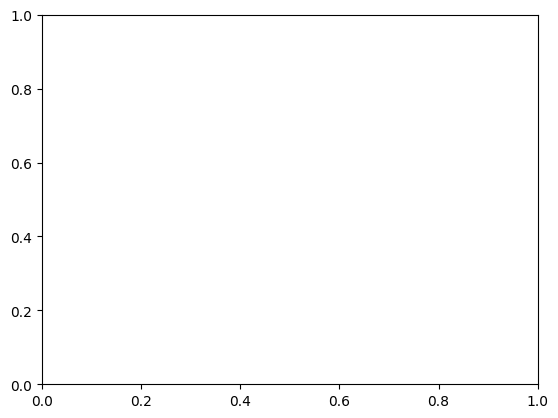

In [27]:
from scipy.stats import invgamma

xs = np.linspace(0, 3, 1000)  # Define values of x
mu = 0
sigma = 1
fig, ax = plt.subplots()
ax.plot(xs, [inv_gamma_pdf(x, 1, 1) for x in xs], label=f'$\\alpha={1}$, $\\beta={1}$')
ax.set_ylabel('P($\\sigma$)')
ax.set_xlabel('$\\sigma$')
ax.legend()
plt.tight_layout()
plt.show()
plt.close()

I ended up with 1 and 1, seems about reasonable: small variance values are most likely, but larger ones are also not too unlikely. It feels right to me and that is what matters. Typically, you would not just randomly pick values that seem to make sense for this one, but instead base these parameters following some standards and conventions (which I will discuss later in the book), but for now, given we are just trying to illustrate how things work, that's good enough.

## Multivariate priors or multiplied univariate priors?

Above, we presented what reasonable priors for each parameters would be in isolation. But what we need ultimately is the prior distribution of all our parameters. Should we combine them somehow, multiply them together perhaps...? The answer kind of depends on our belief about the relationship between the parameters of our model.

In the case of the likelihood, we couldn't simply multiply the likelihood of $P(y|\beta_0)$ and $P(y|\beta_1)$, because that would imply that the likelihood of the data given each parameter is independent of the other parameters. That is not the case in a linear regression, because the likelihood of the data depends on the combination of all parameters, as the parameters interact in determining the predicted values. Therefore, the likelihood must be modeled as a function of all parameters combined to accurately reflect their dependencies

For the priors however, we are expressing our belief in the likely values of $\beta_0$ and $\beta_1$ and $\sigma$ before observing the data. Whether we can represent the joint prior distribution as the product of the individual priors depends on whether we believe the parameters are independent a priori. Remember, when you multiply individual probability distributions to form a joint distribution, you are assuming that the variables are independent. So in a nutshell, you have two options:

- If you believe that your parameters are independent of each other a priori, you can create a prior for each independently and multiply them to obtain the joint prior distribution.
- If you believe that the parameters are not independent, you should specify your prior as a multivariate distribution, capturing the relationships between the parameters through their covariance.

If you find the word **multivariate** confusing, remember that that's exactly the kind of distribution we have for the likleihood: it is a distribution that takes in several parameters (such as $\beta_0$ and $\beta_1$) and return a likelihood of a variable given the value of each input. In contrast, a univariate takes a single parameter and returns a likelihood at the given value of that parameter (just as we have in the graphs above). So don't it mixed up with the concepts of multivarite analyses, such as MVPA, MANOVA, machine learning... 

### When are the parameters correlated?
We saw before an example of the $beta_0$ and $beta_1$ parameters being correlated when $x$ wasn't centered, but that's probably still a little bit confusing. It is really important to understand what a correlation between the $\beta$ parameters implies. It is probably especially confusing because you are used to think of the $\beta$ in terms of a single estimate for each $\beta$ that gives you the line of best fit for your regression model, estimated with the OLS. Another thing that is easy to get mixed up is the concept of **multi-colinearity** between your regressors, which is **not the same thing**. Imagine you are modelling the penguin weight as a function of the flipper length, but also the height of penguins. You would expect that the height of the penguin should be correlated with the length of their flipper. In other words, you would expect the $x_1$ (flipper length) and $x_2$ (penguin height) to be correlated with one another. When you have the regressors themselves (the $x$ part of the model, what we call the **design matrix**), we say that there is multi-colinearity in our regressors, which is not the same as having a correlation (or covariance) between your $\beta$ parameters! You can have regressors that are correlated while the $\beta$ remain independent. 

But then, what does it even mean that the $\beta$ parameters can be correlated? What would it even look like? When does it happen? On the face of it, it is pretty simple: stating that you believe that there is a correlation between the $\beta$ is basically saying that you believe that high value of one $\beta$ are more likely if one (or several) other $\beta$ are also higher if you have a positive covariance between the two. Or the other way around, that high value of one $\beta$ are more likely if you have low values in one  (or several) other $\beta$. When should that be the case? Let's try to illustrate this with an intuitive example. 

THINK OF A GOOD EXAMPLE USING PENGUINS

So basically, the intuition here is that you should specify that the $\beta$ covary in your prior if you have reason to believe that observing some value of one $\beta$ has implication for other $\beta$. This can be in two directions: 
- either you believe that if you observe large value in one $\beta$ means you probably also have large values in another $\beta$, in which case you have a positive covariance between two, 
- or you believe that if you observe a large value for one $\beta$, then you would expect the value of another $\beta$ to be lower

### Joint prior distributions

In our linear model, we have two different families of parameters so to speak: the $\beta$ and the $\sigma$. We will never specify a multivariate distribution combining the prior belief of the $\beta$ and $\sigma$ together, because we always assume that the two are independent. It is in fact an assumption of the linear model: the error should be independent from the $\beta$. Furthermore, the distribution of the $\sigma$ is always univariate in a linear model. And in the rest of the book, we will use the prior to be an inverse gamma. So we know that the prior distribution is something like this:

$$P(\Theta) = P(\beta_0, \beta_1, \beta_2...) \times \mathcal{Inverse-Gamma}(a, b)$$

Where: 
- $\mathcal{Inverse-Gamma}$: inverse gamma PDF for the $\sigma$
- $a$: shape parameter of the gamma distribution. This value reflects our prior belief about the error together with b
- $b$: scale parameter of the gamma distribution. This value reflects our prior belief about the error together with a
- P(\beta_0, \beta_1, \beta_2...): distribution of the $\beta$ parameters

Okay, so that leaves us with the $P(\beta_0, \beta_1, \beta_2...)$, the distribution of our beta. What should it be? We have two options:

$$P(\beta_0, \beta_1, \beta_2...) = P(\beta_0) \times P(\beta_1) \times P(\beta_2)...$$

If we believe that all parameters are independent, where $\beta_i \sim \mathcal{N}(\mu_i, \sigma_i)$

Or, if you believe that the beta parameter are related somehow:

$$\Beta \sim \mathcal{N}(\mu, \Sigma)$$

Where $\mu$ is the prior of the mean of each $\beta$ and $\Sigma$ (which is capital $\sigma$) is a matrix reflecting the prior $\sigma^2$ (or variance) estimate for each $\beta$ as well as the covariance between each pairs of $\beta$. 

Eventhough you have the choice between the two in theories, we will always go for option 2. The main reason is that it is more general: if you believe that the $\beta$ are independent from each other, you can use the second approach and specify that the covariance between the $\beta$ is 0, which is equivalent to saying that they are independent and therefore is equivalent to multiplying the prior probablity of each $\beta$ together. So you can use option 2 to express option 1, but you can't use option 1 to express option 2. 

Now let's dig a bit more in the details of the prior probability of the $\beta$

### Multivariate probability distribution of the betas
In the formulae above, we have the $\mu$ parameter, which takes a single value for each $\beta$. That's simple enough, we can just say:

$$\mu = [\mu_{\beta_0}, \mu_{\beta_1}]$$

And we said before that we have the following values:

$$\mu = [30, 0]$$

What about the $\Sigma$ parameter? This one is a bit more complicated. It is the **Variance-covariance matrix**. That matrix has one column per $\beta$ and also one row per $\beta$. So in our penguin example, we have a 2 by 2 matrix. It encodes the relationship between each parameters:

| |$\beta_0$ | $\beta_1$|
| - | - | - |
|$\beta_0$ | $Cov(\beta_0, \beta_0)$ | $Cov(\beta_0, \beta_1)$ |
|$\beta_1$ |$Cov(\beta_1, \beta_0)$|$Cov(\beta_1, \beta_1)$|

Again, the concept of covariance between the $\beta$ may be quite confusing. Remember that it is not the same as having a correlation between your predictors (the $x$ part of your model, which is also called the **design matrix**). The covariance between two variables is the same thing as the correlation, except it is not normalized to be between -1 and 1. But it is still signed, which means that if you have a positive covariance, it means that if you have a large value in one variable, you have a large value in the other. You might be most familiar with the covariance as something we calculate based on some observed data. You can for example compute the covariance between your predictors, say $x_1$ and $x_2$. If you have a positive or a negative covariance between the two, then we say that there is multicolinearity in your design matrix, as we have established before. 

The formulae for the covariance is the following:

$$Cov(x_0, x_1) = \frac{1}{n-1} \sum_{i=1}^{n}(x_{0i}-\bar{x_0})(x_{1i}-\bar{x_1})$$

Where:
- $x_{0i}$: The $i$-th observation of variable $x_0$ (in general, not the $x_0$ of our model)
- $x_{i}$: The $i$-th observation of variable $x_1$ (in general, not the $x_1$ of our model)
- $\hat{x_0}$: mean of $x_0$
- $\hat{x_1}$: mean of $x_1$

In this case, it is not something we compute, because we are talking about prior here: this is what we believe reghardless of any data. As we have established, the covariance between two $\beta$ means that we believe there is some relationship between the two. If we believe that there is a positive relationship between two variables, we can put a positive value in that slot. If we believe there is a negative relationship between the two, we put a negative value in the right slot. Note that it is a symetrical matrix, so you should put the same value on both sides of  the diagonal. But what about the diagonal? What should the covariance of a parameter with itself be? If we look at the formulae, that becomes self-evident:

$$Cov(\beta_0, beta_0) = \frac{1}{n-1} \sum_{i=1}^{n}(\beta_{1i}-\bar{\beta_1})(\beta_{1i}-\bar{\beta_1})$$

$$Cov(\beta_0, \beta_0) = \frac{1}{n-1} \sum_{i=1}^{n}(\beta_{1i}-\bar{\beta_1})^2$$

Which is... The variance $\sigma^2$. So yes, along the diagonal is the variance of a specific parameter. So the matrix $\Sigma$ is this:

| |$\beta_0$ | $\beta_1$|
| - | - | - |
|$\beta_0$ | $\sigma_0^2$ | $Cov(\beta_0, \beta_1)$ |
|$\beta_1$ |$Cov(\beta_1, \beta_0)$|$\sigma_1^2$ |

So it all adds up now. When we looked for reasonable parameters for the priors of each parameters, we specified the $\alpha$ and $\beta$ parameters for the inverse gamma of the $\epsilon$ parameter, $\mu$ and $\sigma$ for each of the $\beta$ parameter, which are all part of the formulae we have stated just above. The only extra thing is that we have the option to specify the covariance between the $\beta$ if we have reasons to believe that they should be linked somehow. Before we can combine the prior of the $\epsilon$ and of the $\beta$, we need to state the actual formulae of the mutlivariate distribution for the $\beta$, because so far, we have only stated it $\mathcal{\beta} \sim \mathcal{N}(\mu, \Sigma)$

Just as was the case for the likelihood, the prior distribution of the $\beta$ parameter is a multivariate distribution. So it is written like so:

$$P(\mathcal{\beta}) = \frac{1}{(2*\pi)^{p/2}|\mathcal{\Sigma}|^{1/2}}exp(-\frac{1}{2}(\mathcal{\beta} - \mathcal{\mu})^T\Sigma^{-1}(\mathcal{\beta}-\mathcal{\mu}))$$

You may notice that this looks very similar to other formulae you have encountered in previous chapters. That is to be expected: the likelihood is a multivariate normal distribution, and so is the prior distribution of the $\beta$. You might feel a bit lost and confused, because we have different things that look the same (the prior and the likelihood), but also the same thing that looks different (different ways of writing the same thing with the matrix notation). Bear with me for a little bit longer, we will have a very clear recap table in the next chapter, where everything will be laid out clearly. 

There is also quite a bit of matrix notation in the above, which may be difficult to read if you aren't familiar with it. Let's implement this distribution programatically to see more clearly what's going on:

In [ ]:
def multivariate_normal_pdf(beta, mu, Sigma):
    """
    Computes the probability density function of a multivariate normal distribution.
    
    Parameters:
    - beta : np.ndarray
        A 1D array of shape (p,) representing the point at which to evaluate the PDF.
    - mu : np.ndarray
        A 1D array of shape (p,) representing the mean vector of the distribution.
    - Sigma : np.ndarray
        A 2D array of shape (p, p) representing the covariance matrix of the distribution.
        
    Returns:
    - float
        The value of the PDF evaluated at beta.
        
    Notes:
    The multivariate normal PDF is given by:
    
        P(beta) = (1 / ((2 * pi)^(p/2) * |Sigma|^(1/2))) * 
                  exp(-0.5 * (beta - mu)^T * Sigma^{-1} * (beta - mu))
                  
    where:
    - p is the dimensionality of beta,
    - |Sigma| is the determinant of the covariance matrix,
    - Sigma^{-1} is the inverse of the covariance matrix.
    """
    beta = np.asarray(beta)
    mu = np.asarray(mu)
    Sigma = np.asarray(Sigma)
    
    # Ensure that beta and mu are 1D arrays
    if beta.ndim != 1 or mu.ndim != 1:
        raise ValueError("beta and mu must be 1-dimensional arrays.")
    
    # Ensure that Sigma is a 2D square matrix
    if Sigma.ndim != 2 or Sigma.shape[0] != Sigma.shape[1]:
        raise ValueError("Sigma must be a 2-dimensional square matrix.")
    
    p = beta.shape[0]
    
    # Check that the dimensions match
    if mu.shape[0] != p or Sigma.shape[0] != p:
        raise ValueError("Dimensions of beta, mu, and Sigma do not match.")
    
    # Compute the determinant and inverse of Sigma
    det_Sigma = np.linalg.det(Sigma)
    if det_Sigma <= 0:
        raise ValueError("The covariance matrix Sigma must be positive definite.")
    
    inv_Sigma = np.linalg.inv(Sigma)
    
    # Compute the normalization constant
    norm_const = 1.0 / (np.power(2 * np.pi, p / 2) * np.sqrt(det_Sigma))
    
    # Compute the exponent
    diff = beta - mu
    exponent = -0.5 * np.dot(diff.T, np.dot(inv_Sigma, diff))
    
    # Compute the PDF value
    pdf = norm_const * np.exp(exponent)
    
    return pdf

Okay, now we can check out what that multivariate distribution looks like for various prior parameters. Let's start by plotting the prior distribution for the parameters we have selected:

Prior means: [30  0]
Prior covariance: [[15  0]
 [ 0  5]]


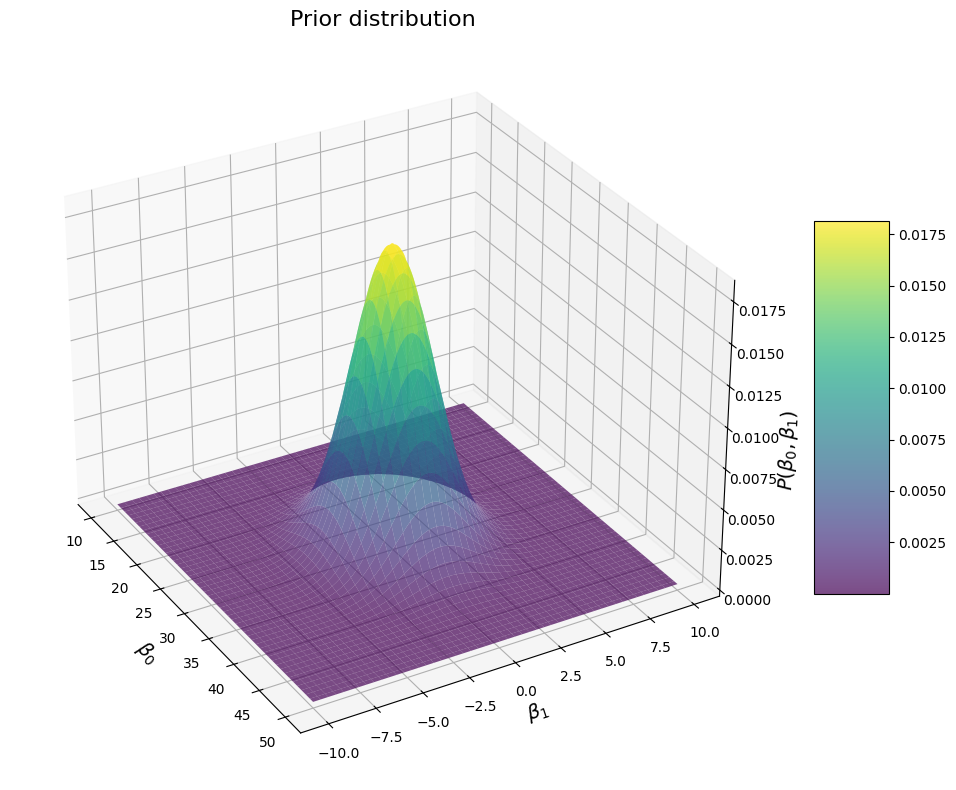

In [ ]:
from matplotlib import cm
# Specify our priors:
mu = np.array([30, 0])  # mean penguin weight of about 30kg, and a prior mean of 0 for the correlation between their flipper length and their weight
sigma = np.array([[15, 0], [0, 5]])  # assuming a variance of 15^2 for penguin weights, and 5 for  the slope of the regression, no covariance
print(f"Prior means: {mu}")
print(f"Prior covariance: {sigma}")

# Beta pairs over which to estimate the PDF:
betas = np.squeeze(np.array([[np.linspace(mu[0]-20, mu[0]+20, 200)], [np.linspace(mu[1]-10, mu[1]+10, 200)]]))  # Instead of creating a separate variable for b0 and b1, combining them in one array, which is intuitively more similar with the matrix notation

B0s, B1s  = np.meshgrid(betas[0], betas[1])

# Compute the prior distribution:
pdf = np.zeros(B0s.shape)
for i in range(betas.shape[-1]):
    for ii in range(betas.shape[-1]):
        pdf[i, ii] = multivariate_normal_pdf(np.array([betas[0, i], betas[1, ii]]), mu, sigma)


# Plot the distribution over these beta values:
# Create the plot
fig = plt.figure(figsize=(12, 8))
ax = fig.add_subplot(111, projection='3d')
# Plot the surface
surf = ax.plot_surface(B0s, B1s, pdf, cmap=cm.viridis, linewidth=0, antialiased=True, alpha=0.7)
# Customize the axes
ax.set_xlabel(r'$\beta_0$', fontsize=14)
ax.set_ylabel(r'$\beta_1$', fontsize=14)
ax.set_zlabel(r'$P(\beta_0, \beta_1)$', fontsize=14)
ax.set_title(f'Prior distribution', fontsize=16)
# Adjust viewing angle for better visualization
ax.view_init(elev=30, azim=-30)
# Add a color bar
fig.colorbar(surf, shrink=0.5, aspect=5)
plt.tight_layout()
plt.show()
plt.close()

That looks about like what we woukld expect: once again a nice bell around the values that we believe are most likely. Obviously, if we increase the sigma for each $\beta$, we get a wider distribution:

Prior means: [30  0]
Prior covariance: [[20  0]
 [ 0 10]]


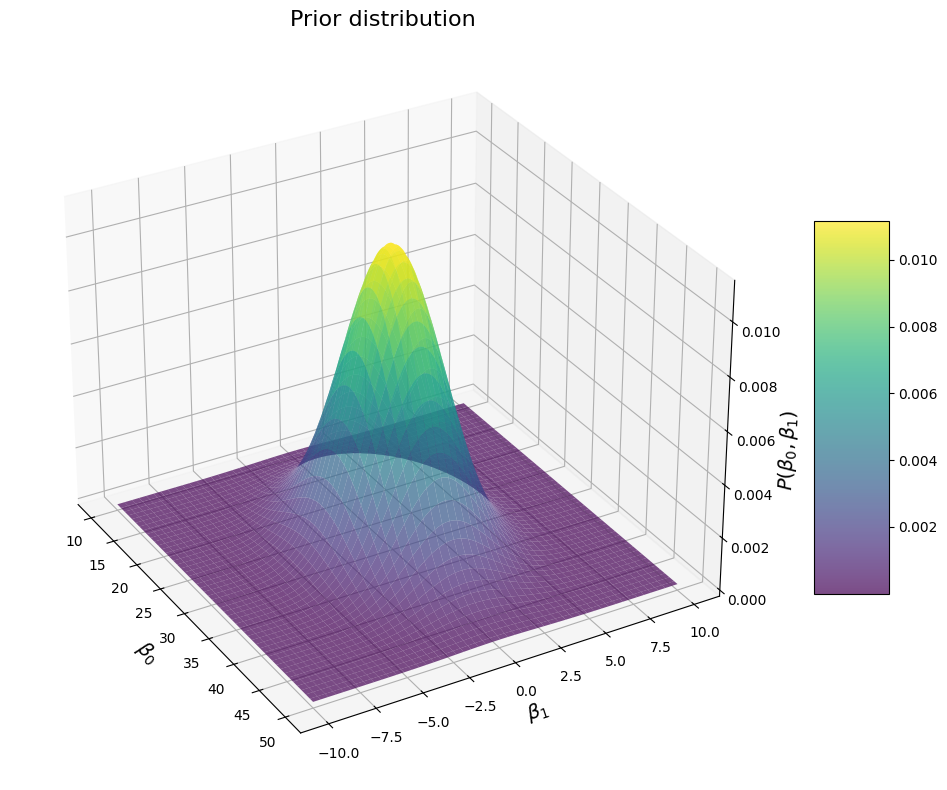

In [ ]:
# Specify our priors:
mu = np.array([30, 0])  # mean penguin weight of about 30kg, and a prior mean of 0 for the correlation between their flipper length and their weight
sigma = np.array([[20, 0], [0, 10]])  # assuming a variance of 15^2 for penguin weights, and 5 for  the slope of the regression, no covariance
print(f"Prior means: {mu}")
print(f"Prior covariance: {sigma}")

# Beta pairs over which to estimate the PDF:
betas = np.squeeze(np.array([[np.linspace(mu[0]-20, mu[0]+20, 200)], [np.linspace(mu[1]-10, mu[1]+10, 200)]]))  # Instead of creating a separate variable for b0 and b1, combining them in one array, which is intuitively more similar with the matrix notation

B0s, B1s  = np.meshgrid(betas[0], betas[1])

# Compute the prior distribution:
pdf = np.zeros(B0s.shape)
for i in range(betas.shape[-1]):
    for ii in range(betas.shape[-1]):
        pdf[i, ii] = multivariate_normal_pdf(np.array([betas[0, i], betas[1, ii]]), mu, sigma)


# Plot the distribution over these beta values:
# Create the plot
fig = plt.figure(figsize=(12, 8))
ax = fig.add_subplot(111, projection='3d')
# Plot the surface
surf = ax.plot_surface(B0s, B1s, pdf, cmap=cm.viridis, linewidth=0, antialiased=True, alpha=0.7)
# Customize the axes
ax.set_xlabel(r'$\beta_0$', fontsize=14)
ax.set_ylabel(r'$\beta_1$', fontsize=14)
ax.set_zlabel(r'$P(\beta_0, \beta_1)$', fontsize=14)
ax.set_title(f'Prior distribution', fontsize=16)
# Adjust viewing angle for better visualization
ax.view_init(elev=30, azim=-30)
# Add a color bar
fig.colorbar(surf, shrink=0.5, aspect=5)
plt.tight_layout()
plt.show()
plt.close()

And a peaker distribution if we set the $\sigma$ of the $\beta$ to smaller values:

Prior means: [30  0]
Prior covariance: [[2 0]
 [0 1]]


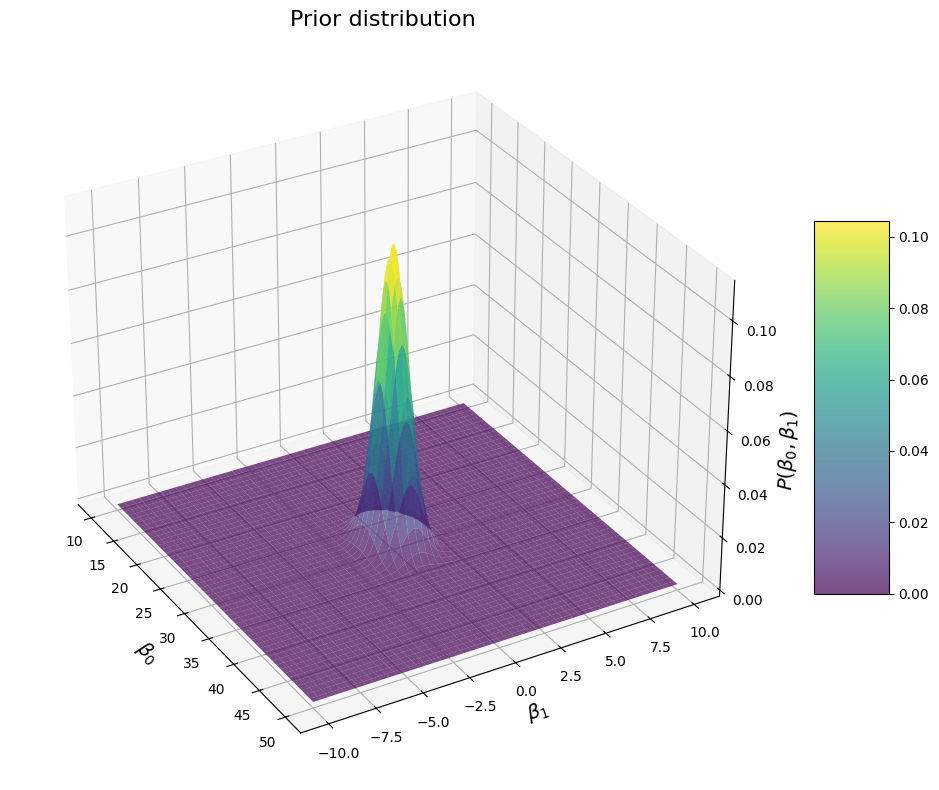

In [ ]:
# Specify our priors:
mu = np.array([30, 0])  # mean penguin weight of about 30kg, and a prior mean of 0 for the correlation between their flipper length and their weight
sigma = np.array([[2, 0], [0, 1]])  # assuming a variance of 15^2 for penguin weights, and 5 for  the slope of the regression, no covariance
print(f"Prior means: {mu}")
print(f"Prior covariance: {sigma}")

# Beta pairs over which to estimate the PDF:
betas = np.squeeze(np.array([[np.linspace(mu[0]-20, mu[0]+20, 200)], [np.linspace(mu[1]-10, mu[1]+10, 200)]]))  # Instead of creating a separate variable for b0 and b1, combining them in one array, which is intuitively more similar with the matrix notation

B0s, B1s  = np.meshgrid(betas[0], betas[1])

# Compute the prior distribution:
pdf = np.zeros(B0s.shape)
for i in range(betas.shape[-1]):
    for ii in range(betas.shape[-1]):
        pdf[i, ii] = multivariate_normal_pdf(np.array([betas[0, i], betas[1, ii]]), mu, sigma)


# Plot the distribution over these beta values:
# Create the plot
fig = plt.figure(figsize=(12, 8))
ax = fig.add_subplot(111, projection='3d')
# Plot the surface
surf = ax.plot_surface(B0s, B1s, pdf, cmap=cm.viridis, linewidth=0, antialiased=True, alpha=0.7)
# Customize the axes
ax.set_xlabel(r'$\beta_0$', fontsize=14)
ax.set_ylabel(r'$\beta_1$', fontsize=14)
ax.set_zlabel(r'$P(\beta_0, \beta_1)$', fontsize=14)
ax.set_title(f'Prior distribution', fontsize=16)
# Adjust viewing angle for better visualization
ax.view_init(elev=30, azim=-30)
# Add a color bar
fig.colorbar(surf, shrink=0.5, aspect=5)
plt.tight_layout()
plt.show()
plt.close()

Now let's have a look at what happens if we specify some covariance between the betas:

Prior means: [30  0]
Prior covariance: [[2 1]
 [1 1]]


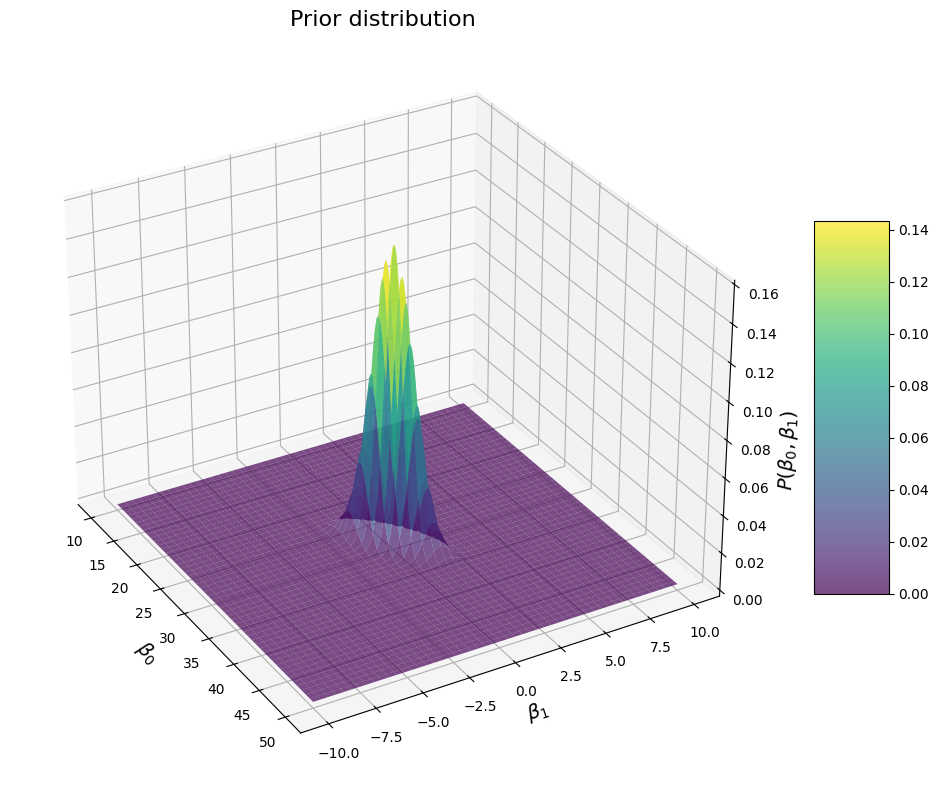

In [ ]:
# Specify our priors:
mu = np.array([30, 0])  # mean penguin weight of about 30kg, and a prior mean of 0 for the correlation between their flipper length and their weight
sigma = np.array([[2, 1], [1, 1]])  # assuming a variance of 15^2 for penguin weights, and 5 for  the slope of the regression, no covariance
print(f"Prior means: {mu}")
print(f"Prior covariance: {sigma}")

# Beta pairs over which to estimate the PDF:
betas = np.squeeze(np.array([[np.linspace(mu[0]-20, mu[0]+20, 200)], [np.linspace(mu[1]-10, mu[1]+10, 200)]]))  # Instead of creating a separate variable for b0 and b1, combining them in one array, which is intuitively more similar with the matrix notation

B0s, B1s  = np.meshgrid(betas[0], betas[1])

# Compute the prior distribution:
pdf = np.zeros(B0s.shape)
for i in range(betas.shape[-1]):
    for ii in range(betas.shape[-1]):
        pdf[i, ii] = multivariate_normal_pdf(np.array([betas[0, i], betas[1, ii]]), mu, sigma)


# Plot the distribution over these beta values:
# Create the plot
fig = plt.figure(figsize=(12, 8))
ax = fig.add_subplot(111, projection='3d')
# Plot the surface
surf = ax.plot_surface(B0s, B1s, pdf, cmap=cm.viridis, linewidth=0, antialiased=True, alpha=0.7)
# Customize the axes
ax.set_xlabel(r'$\beta_0$', fontsize=14)
ax.set_ylabel(r'$\beta_1$', fontsize=14)
ax.set_zlabel(r'$P(\beta_0, \beta_1)$', fontsize=14)
ax.set_title(f'Prior distribution', fontsize=16)
# Adjust viewing angle for better visualization
ax.view_init(elev=30, azim=-30)
# Add a color bar
fig.colorbar(surf, shrink=0.5, aspect=5)
plt.tight_layout()
plt.show()
plt.close()

We see this ridge shape again. In this case, the direction of the ridge is such that values of $\beta_1$ are more likely when $\beta_0$ is large (or the other way around). This makes sense because we specified a positive covariance. If we specify a negative value, we get this:

Prior means: [30  0]
Prior covariance: [[ 2 -1]
 [-1  1]]


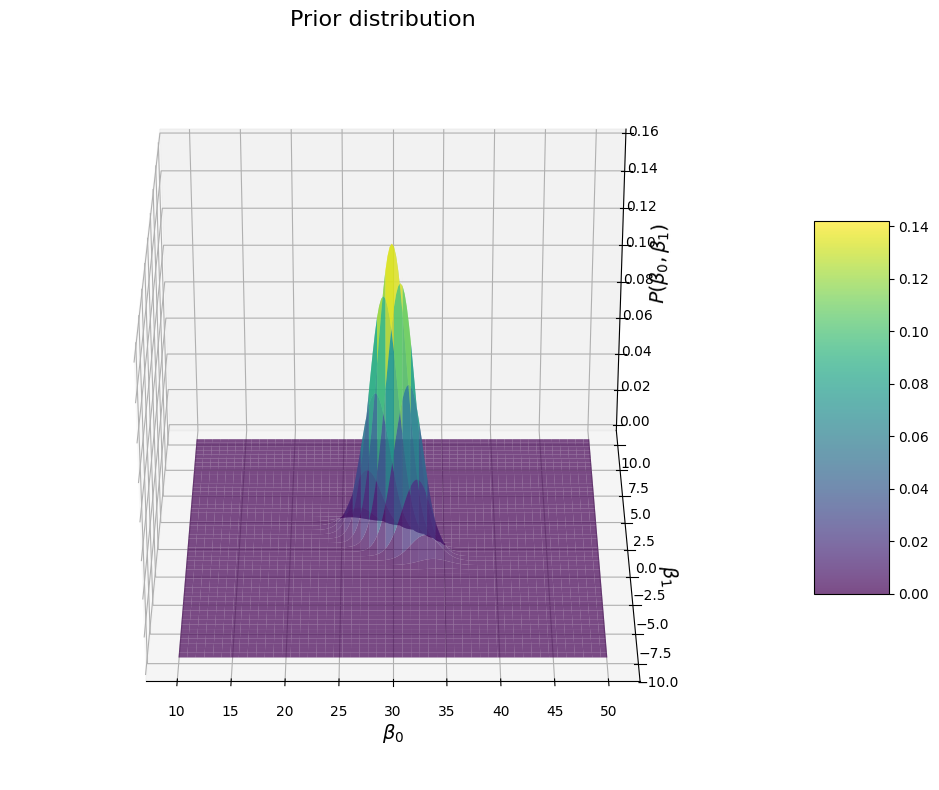

In [ ]:
# Specify our priors:
mu = np.array([30, 0])  # mean penguin weight of about 30kg, and a prior mean of 0 for the correlation between their flipper length and their weight
sigma = np.array([[2, -1], [-1, 1]])  # assuming a variance of 15^2 for penguin weights, and 5 for  the slope of the regression, no covariance
print(f"Prior means: {mu}")
print(f"Prior covariance: {sigma}")

# Beta pairs over which to estimate the PDF:
betas = np.squeeze(np.array([[np.linspace(mu[0]-20, mu[0]+20, 200)], [np.linspace(mu[1]-10, mu[1]+10, 200)]]))  # Instead of creating a separate variable for b0 and b1, combining them in one array, which is intuitively more similar with the matrix notation

B0s, B1s  = np.meshgrid(betas[0], betas[1])

# Compute the prior distribution:
pdf = np.zeros(B0s.shape)
for i in range(betas.shape[-1]):
    for ii in range(betas.shape[-1]):
        pdf[i, ii] = multivariate_normal_pdf(np.array([betas[0, i], betas[1, ii]]), mu, sigma)


# Plot the distribution over these beta values:
# Create the plot
fig = plt.figure(figsize=(12, 8))
ax = fig.add_subplot(111, projection='3d')
# Plot the surface
surf = ax.plot_surface(B0s, B1s, pdf, cmap=cm.viridis, linewidth=0, antialiased=True, alpha=0.7)
# Customize the axes
ax.set_xlabel(r'$\beta_0$', fontsize=14)
ax.set_ylabel(r'$\beta_1$', fontsize=14)
ax.set_zlabel(r'$P(\beta_0, \beta_1)$', fontsize=14)
ax.set_title(f'Prior distribution', fontsize=16)
# Adjust viewing angle for better visualization
ax.view_init(elev=30, azim=-90)
# Add a color bar
fig.colorbar(surf, shrink=0.5, aspect=5)
plt.tight_layout()
plt.show()
plt.close()

Again a ridge shape (careful, I changed the view of the graph for better vizualization), but this time the direction of the ridge is the opposite: $\beta_1$ values are more likely when $\beta_0$ is small and reciprocally.

## The joint prior: combining the prior of the $\beta$ and $\epsilon$
So now, we know the following:

$$P(\sigma^2) = \frac{\beta^\alpha}{\Gamma(\alpha)}(\sigma^2)^{-\alpha-1}exp(-\frac{\beta}{\sigma^2})$$

And:

$$P(\mathcal{\beta}) = \frac{1}{(2*\pi)^{p/2}|\mathcal{\Sigma}|^{1/2}}exp(-\frac{1}{2}(\mathcal{\beta} - \mathcal{\mu})^T\Sigma^{-1}(\mathcal{\beta}-\mathcal{\mu}))$$

And we assume that the two are independent, so we have:

$$P(\Theta) = P(\beta, \sigma^2) = P(\mathcal{\beta}) \times P(\sigma^2)$$

We can replace each by its respective formula:

$$P(\Theta) = \bigg(\frac{1}{(2*\pi)^{p/2}|\mathcal{\Sigma}|^{1/2}}exp\big(-\frac{1}{2}(\mathcal{\beta} - \mathcal{\mu})^T\Sigma^{-1}(\mathcal{\beta}-\mathcal{\mu})\big)\bigg) \times \bigg(\frac{\beta^\alpha}{\Gamma(\alpha)}(\sigma^2)^{-\alpha-1}exp(-\frac{\beta}{\sigma^2})\bigg)$$

In this case, that's where it ends, we can't rearange much to simplify the expression. So we will have to stick to this beefy formula.

So that's it, we have the formula for our prior distribution, so we can move on to the next step, in which we deal with the integral part in the numerator. But before doing this, we will have a brief recap, cause that was a bit much already